In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

In [2]:

import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[0,255, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    slopethresholdmin = 0.53
    slopethresholdmax = 1.25

    
    #draw canditate lanes for lanes with white
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (x2-x1) != 0 :
                slope = abs(((y2-y1)/(x2-x1)))
                
                if slope > slopethresholdmin and slope < slopethresholdmax :
                    #only draw canditate lines 
                    cv2.line(img, (x1, y1), (x2, y2), color, thickness)



def draw_lanes(img, lines, color=[255, 0, 0], thickness=6):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    leftlaneslope = 0
    rightlaneslope = 0
    numrightlines = 0
    numleftlines = 0
    leftx = 0
    rightx = 10000
    lefty =  -10000
    righty = -10000
    #ignore near horizantal lines
    slopethresholdmin = 0.53
    slopethresholdmax = 1.25
    lanelength = 0
    
    imshape = img.shape
    
    # calculate the slope of left and right lanes by taking an average over the slopes
    
    for line in lines:
        for x1,y1,x2,y2 in line:

            # convert y to negative values makes easier to understand
            y1 = y1 * -1
            y2 = y2 * -1
            
            if (x2-x1) != 0 :
                slope = ((y2-y1)/(x2-x1))
                
                linelength = math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))            
        
            
                if slope > slopethresholdmin and slope < slopethresholdmax :
                    #print(str(slope) + " : " + str(x1) + " " + str(y1) + " " + str(x2) + " " + str(y2) + "--" + str(linelength) )
 
                    #positive slope means left lane
                
                    #calculate the maximum y for the left lane
                    if lefty < y1 :
                        lefty = y1
                    if lefty < y2 :
                        lefty = y2
                   
                    numleftlines = numleftlines + 1
                    leftlaneslope = leftlaneslope + slope
                
                    #find the maxiumum x for the left lane
                    if x1 > leftx :
                        leftx = x1
                    if x2 > leftx :
                        leftx = x2
                    
            
                if slope < (-1 * slopethresholdmin) and slope > (-1 * slopethresholdmax) :
                    #print(str(slope) + " : " + str(x1) + " " + str(y1) + " " + str(x2) + " " + str(y2) + "--" + str(linelength) )


                    #calculate the maximum y for the right lane
                    if righty < y1 :
                        righty = y1
                    if righty < y2 :
                        righty = y2

                
                    numrightlines = numrightlines + 1
                    rightlaneslope = rightlaneslope + slope
                
                    if x1 < rightx :
                        rightx = x1
                    if x2 < rightx :
                        rightx = x2
    
    if numrightlines!=0 :
    
        righty = righty * -1
        rightlaneslope = rightlaneslope / numrightlines        
        cv2.line(img, (rightx - int((imshape[0]-righty)/rightlaneslope), imshape[0]), (rightx , righty), color, thickness)
  
    if numleftlines !=0 :
    
        lefty= lefty * -1      
        leftlaneslope =  leftlaneslope / numleftlines
        cv2.line(img, (leftx - int((imshape[0]-lefty)/leftlaneslope), imshape[0]), (leftx, lefty), color, thickness)  

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [3]:
#lane detection


def lane_detect(image):
    plt.figure()
    
    gray = grayscale(image)

    #plt.imshow(gray,cmap='gray')
    #apply Gaussian smoothing
    
    # print('Gray Image : ')
    blur_gray = gaussian_blur(gray,5)

    # plt.imshow(blur_gray,cmap='gray')
    
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # plt.imshow(edges)
    # Next we'll create a masked edges image using cv2.fillPoly() 

    # Create a region of interest
    imshape = image.shape
    vertices = np.array([[(130,imshape[0]),(470, 315), (imshape[1]-460, 315), (imshape[1]-50,imshape[0])]], dtype=np.int32)

    ROIimg = region_of_interest(edges,vertices)

    #plt.imshow(ROIimg)
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 2     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(ROIimg, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
    draw_lines(line_image,lines)
    draw_lanes(line_image,lines)
 

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = weighted_img(line_image,image) 
    return lines_edges

In [4]:
def lane_detect2(image):
    plt.figure()
    
    gray = grayscale(image)

    #plt.imshow(gray,cmap='gray')
    #apply Gaussian smoothing
    
    # print('Gray Image : ')
    blur_gray = gaussian_blur(gray,5)

    # plt.imshow(blur_gray,cmap='gray')
    
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # plt.imshow(edges)
    # Next we'll create a masked edges image using cv2.fillPoly() 

    # Create a region of interest
    imshape = image.shape
    vertices = np.array([[(250,650),(1100, 650), (750, 450), (610,450)]], dtype=np.int32)

    ROIimg = region_of_interest(edges,vertices)

    #plt.imshow(ROIimg)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 4     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 8    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(ROIimg, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
    if lines is not None:
        draw_lines(line_image,lines)
        draw_lanes(line_image,lines)
 

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = weighted_img(line_image,image) 
    return lines_edges

solidWhiteCurve.jpg
Output Image: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
solidWhiteRight.jpg
Output Image: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
solidYellowCurve.jpg
Output Image: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
solidYellowCurve2.jpg
Output Image: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
solidYellowLeft.jpg
Output Image: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
whiteCarLaneSwitch.jpg
Output Image: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


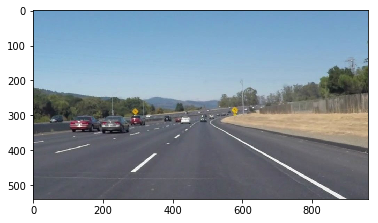

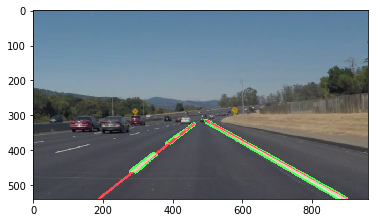

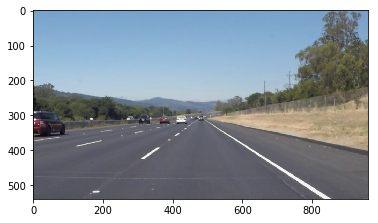

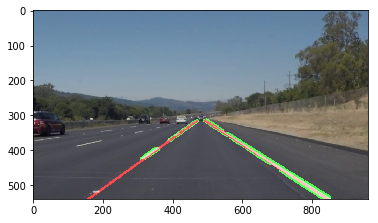

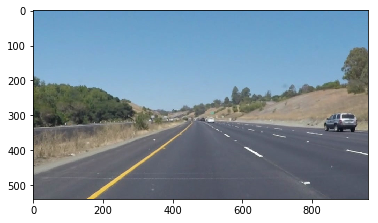

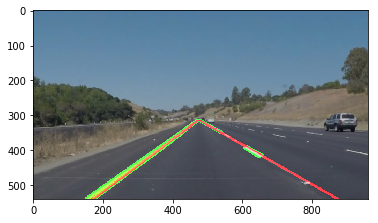

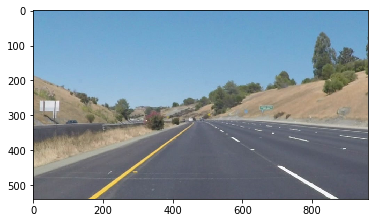

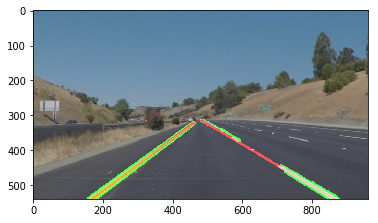

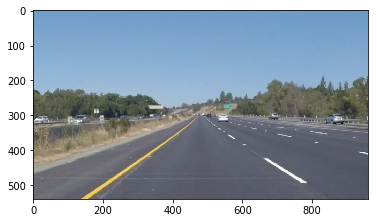

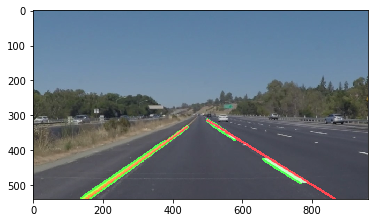

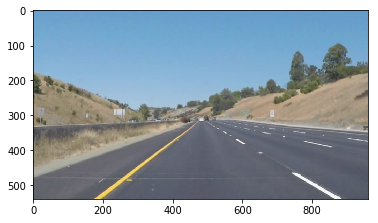

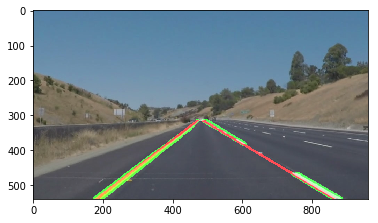

In [5]:
#reading in an image
import os
test_files = os.listdir("test_images/")



for test_file in test_files:
    print (test_file)
    image = mpimg.imread('test_images/' + test_file)
    #printing out some stats and plotting

    plt.figure()
    plt.imshow(image) 
    lane_image = lane_detect(image)
    print('Output Image:', type(image), 'with dimensions:', image.shape)
    plt.figure()
    plt.imshow(lane_image) 

Output Image: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


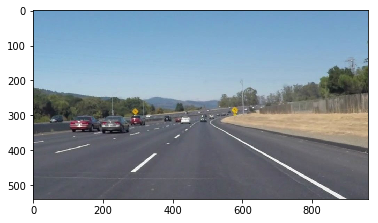

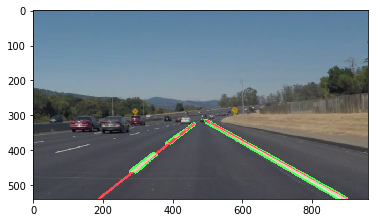

In [6]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#printing out some stats and plotting

plt.figure()
plt.imshow(image) 
lane_image = lane_detect(image)
print('Output Image:', type(image), 'with dimensions:', image.shape)
plt.figure()
plt.imshow(lane_image) 

In [7]:
# For debugging creates a image for each frame so that errors can be seen and tested

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


mp4_video = cv2.VideoCapture("test_videos/challenge.mp4")
print(type(mp4_video))

frameCount = int(mp4_video.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(mp4_video.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(mp4_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
framefps = int(mp4_video.get(cv2.CAP_PROP_FPS))

#create array that will hold all the frames
frames = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))
counter = 0
ret = True
print("FPS" + str(framefps))


while counter < 147 and ret:
   
    
    ret, frames[counter] = mp4_video.read()
    
    if counter > 143 :
        print(str(counter))
        #plt.figure()
        destRGB = cv2.cvtColor(frames[counter], cv2.COLOR_BGR2RGB)  
    
        #plt.imshow(destRGB) 
        lane_image = lane_detect2(destRGB)
        #plt.figure()
        #plt.imshow(lane_image) 
        mpimg.imsave("test_image_out/challange" + str(counter) + ".png",lane_image)

    counter += 1





<class 'cv2.VideoCapture'>
FPS25
144
145
146


In [8]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(lane_detect)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:16<00:00, 40.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.71 s, sys: 2.3 s, total: 12 s
Wall time: 17.3 s


In [9]:
yellow_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidWhiteRight.mp4')
yellow_clip = clip2.fl_image(lane_detect)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:05<00:00, 40.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.26 s, sys: 682 ms, total: 3.95 s
Wall time: 6.07 s


In [10]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(lane_detect2)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:11<00:00, 21.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 5.76 s, sys: 2.08 s, total: 7.85 s
Wall time: 12.9 s
